In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train Data Loading

In [3]:
train_data = pd.read_excel('../../Data/train_data.xlsx')
train_data = train_data.convert_dtypes()
train_data.head()

,y,age,job,marital,education,default,balance,housing,loan,contact,day_of_month,month,duration,campaign,pdays,previous,poutcome
0,yes,66,retired,married,secondary,no,2048,no,no,cellular,27,aug,212,1,-1,0,Not Specified
1,no,49,admin.,single,primary,no,181,yes,no,Not Specified,8,may,161,3,-1,0,Not Specified
2,no,41,blue-collar,divorced,primary,no,-129,yes,no,cellular,18,may,176,1,-1,0,Not Specified
3,no,42,Not Specified,single,Not Specified,no,1316,no,no,Not Specified,5,jun,285,1,-1,0,Not Specified
4,no,45,services,married,secondary,no,1621,no,no,cellular,18,aug,122,8,-1,0,Not Specified


In [4]:
train_data['month_segment'] = pd.cut(
    train_data['day_of_month'],
    bins=[0, 10, 20, 31],
    labels=['start', 'mid', 'end'],
    include_lowest=True
)

categorical_cols = train_data.select_dtypes(include = ['string', 'category']).columns
train_data[categorical_cols] = train_data[categorical_cols].astype('category')
train_data = train_data[categorical_cols].copy()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168 entries, 0 to 36167
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   y              36168 non-null  category
 1   job            36168 non-null  category
 2   marital        36168 non-null  category
 3   education      36168 non-null  category
 4   default        36168 non-null  category
 5   housing        36168 non-null  category
 6   loan           36168 non-null  category
 7   contact        36168 non-null  category
 8   month          36168 non-null  category
 9   poutcome       36168 non-null  category
 10  month_segment  36168 non-null  category
dtypes: category(11)
memory usage: 390.7 KB


In [5]:
categories = 0

for col in categorical_cols:
    cat = len(train_data[col].unique())
    categories += cat
    print(f'{col}: {cat}')

print(f'Total: {categories}')

y: 2
job: 12
marital: 3
education: 4
default: 2
housing: 2
loan: 2
contact: 3
month: 12
poutcome: 4
month_segment: 3
Total: 49


# Test Data Loading

In [6]:
test_data = pd.read_excel('../../Data/test_data.xlsx')
test_data = test_data.convert_dtypes()
test_data.head()

,y,age,job,marital,education,default,balance,housing,loan,contact,day_of_month,month,duration,campaign,pdays,previous,poutcome
0,no,42,management,single,tertiary,no,4264,yes,no,Not Specified,28,may,882,1,-1,0,Not Specified
1,no,55,management,married,tertiary,no,0,no,no,Not Specified,30,jun,111,2,-1,0,Not Specified
2,no,45,services,married,secondary,no,4005,yes,no,cellular,17,nov,141,1,-1,0,Not Specified
3,no,51,admin.,married,secondary,no,52,yes,yes,telephone,23,jul,36,15,-1,0,Not Specified
4,no,55,services,married,secondary,no,76,no,no,cellular,5,aug,356,1,-1,0,Not Specified


In [7]:
test_data['month_segment'] = pd.cut(
    test_data['day_of_month'],
    bins=[0, 10, 20, 31],
    labels=['start', 'mid', 'end'],
    include_lowest=True
)

categorical_cols = test_data.select_dtypes(include = ['string', 'category']).columns
test_data[categorical_cols] = test_data[categorical_cols].astype('category')
test_data = test_data[categorical_cols].copy()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9043 entries, 0 to 9042
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   y              9043 non-null   category
 1   job            9043 non-null   category
 2   marital        9043 non-null   category
 3   education      9043 non-null   category
 4   default        9043 non-null   category
 5   housing        9043 non-null   category
 6   loan           9043 non-null   category
 7   contact        9043 non-null   category
 8   month          9043 non-null   category
 9   poutcome       9043 non-null   category
 10  month_segment  9043 non-null   category
dtypes: category(11)
memory usage: 99.3 KB


In [8]:
categories = 0

for col in categorical_cols:
    cat = len(test_data[col].unique())
    categories += cat
    print(f'{col}: {cat}')

print(f'Total: {categories}')

y: 2
job: 12
marital: 3
education: 4
default: 2
housing: 2
loan: 2
contact: 3
month: 12
poutcome: 4
month_segment: 3
Total: 49


# Modeling

In [9]:
cat_cols = train_data.columns[1:]
target_col = "y"

In [10]:
# Evaluation helper
def print_metrics(y_true, y_pred, y_prob):
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=3))
    print(f"ROC AUC: {roc_auc_score(y_true, y_prob):.4f}")

## Naive Bayes

In [11]:
# Encode features and target
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1)
X = enc.fit_transform(train_data[cat_cols])
y = (train_data[target_col] == "yes").astype(int).values

# Train Naive Bayes
model = CategoricalNB()
model.fit(X, y)

# Predict and evaluate on training data
y_pred = model.predict(X)
y_prob = model.predict_proba(X)[:, 1]

# Run evaluation
print_metrics(y, y_pred, y_prob)

Confusion Matrix:
 [[30833  1103]
 [ 3000  1232]]

Classification Report:
               precision    recall  f1-score   support

           0      0.911     0.965     0.938     31936
           1      0.528     0.291     0.375      4232

    accuracy                          0.887     36168
   macro avg      0.719     0.628     0.656     36168
weighted avg      0.866     0.887     0.872     36168

ROC AUC: 0.7498


In [12]:
# ---------------------------
# 2. Priors
# ---------------------------
class_prior = np.exp(model.class_log_prior_)   # shape: (n_classes,)
print("Class priors P(Y):", class_prior)

# ---------------------------
# 3. Conditional probabilities per feature & category
#    feature_log_prob_ is a LIST: len = n_features,
#    each element: array shape (n_classes, n_categories_for_that_feature)
# ---------------------------
nb_tables = {}

for j, col in enumerate(cat_cols):
    log_prob_j = model.feature_log_prob_[j]         # (n_classes, K_j)
    prob_j = np.exp(log_prob_j)                     # convert from log

    categories = enc.categories_[j]                 # original category names
    K = len(categories)

    df = pd.DataFrame({
        "category": categories,
        "P(X_j | Y=0)": prob_j[0, :K],
        "P(X_j | Y=1)": prob_j[1, :K]
    })

    nb_tables[col] = df

    print(f"\n=== Feature: {col} ===")
    print(df)

# ---------------------------
# 4. Posterior probability per sample: P(Y=1 | X)
# ---------------------------
posterior_prob = model.predict_proba(X)[:, 1]

result_df = train_data[cat_cols].copy()
result_df["P(Y=1)"] = posterior_prob

print("\n=== Posterior probabilities (first 10 rows) ===")
print(result_df.head(10))

Class priors P(Y): [0.88299049 0.11700951]

=== Feature: job ===
         category  P(X_j | Y=0)  P(X_j | Y=1)
0   Not Specified      0.006604      0.006362
1          admin.      0.114029      0.118285
2     blue-collar      0.225554      0.136192
3    entrepreneur      0.034149      0.023563
4       housemaid      0.028515      0.019557
5      management      0.204144      0.246701
6         retired      0.044134      0.095900
7   self-employed      0.034994      0.036051
8        services      0.094435      0.068803
9         student      0.016746      0.051367
10     technician      0.168649      0.159519
11     unemployed      0.028046      0.037700

=== Feature: marital ===
   category  P(X_j | Y=0)  P(X_j | Y=1)
0  divorced      0.114280      0.115702
1   married      0.612574      0.525620
2    single      0.273146      0.358678

=== Feature: education ===
        category  P(X_j | Y=0)  P(X_j | Y=1)
0  Not Specified      0.041171      0.048159
1        primary      0.156794   

In [13]:
import numpy as np
import pandas as pd
import plotly.express as px

# -----------------------------------------
# Class priors
# -----------------------------------------
p0, p1 = class_prior
print("P(Y=0) =", p0, "   P(Y=1) =", p1)

# -----------------------------------------
# Function to compute LR and log-LR table
# -----------------------------------------
def nb_feature_table(df):
    out = df.copy()
    out["LR"] = out["P(X_j | Y=1)"] / out["P(X_j | Y=0)"]
    out["log_LR"] = np.log(out["LR"])
    return out

# -----------------------------------------
# Loop over ALL features, Plotly version
# -----------------------------------------
for col in cat_cols:

    # print(f"\n==============================")
    # print(f"Feature: {col}")
    # print(f"==============================")

    df = nb_tables[col]              # per-feature NB probability table
    tab = nb_feature_table(df)
    tab.sort_values(by="log_LR", inplace=True)

    # -----------------------------------------
    # PLOTLY BAR CHART
    # -----------------------------------------
    fig = px.bar(
        tab,
        x="category",
        y="log_LR",
        text=tab["log_LR"].round(3),
        color="log_LR",
        color_continuous_scale="teal",
        title=f"(log-LR) for Feature: {col}"
    )

    fig.update_traces(
        textposition="outside",
        marker_line_width=0,
        textfont=dict(size=16, family="Bahnschrift")
    )

    fig.update_layout(
        height=700, width=700,
        plot_bgcolor="rgba(0,0,0,0)",
        paper_bgcolor="rgba(0,0,0,0)",
        template="plotly_white",
        font=dict(size=18, family="Bahnschrift"),
        title=dict(y=0.95, font=dict(size=26, family="Bahnschrift")),
        xaxis_title="Category",
        yaxis_title="log-LR = log P(X|Y=1) − log P(X|Y=0)",
        coloraxis_showscale=False,
    )

    fig.update_yaxes(showgrid=True, gridcolor="rgba(0,0,0,0.08)")
    fig.write_image(f"../Plots/(log-LR) for Feature {col}.png", scale = 3)
    # fig.show()


P(Y=0) = 0.8829904888299039    P(Y=1) = 0.11700951117009503


In [14]:
train_data['NB_prob'] = y_prob

In [15]:
# Encode features and target
X = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1).fit_transform(test_data[cat_cols])
y = (test_data[target_col] == "yes").astype(int).values

# Predict and evaluate on training data
y_pred = model.predict(X)
y_prob = model.predict_proba(X)[:, 1]

# Run evaluation
print_metrics(y, y_pred, y_prob)

Confusion Matrix:
 [[7766  220]
 [ 766  291]]

Classification Report:
               precision    recall  f1-score   support

           0      0.910     0.972     0.940      7986
           1      0.569     0.275     0.371      1057

    accuracy                          0.891      9043
   macro avg      0.740     0.624     0.656      9043
weighted avg      0.870     0.891     0.874      9043

ROC AUC: 0.7586


In [16]:
test_data['NB_prob'] = y_prob

## Logistic Regression

In [17]:
# One-hot encode categorical features
X = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False).fit_transform(train_data[cat_cols])
y = (train_data['y'] == "yes").astype(int).values

# SMOTE oversampling
sm = SMOTE(random_state = 42)
X_res, y_res = sm.fit_resample(X, y)

# Train logistic regression (with balanced class weights for fairness)
model = LogisticRegression(max_iter=1000, class_weight = 'balanced')
model.fit(X_res, y_res)

# Predict and evaluate
y_pred = model.predict(X)
y_prob = model.predict_proba(X)[:, 1]
print_metrics(y, y_pred, y_prob)

d:\Python\Lib\site-packages\sklearn\base.py:474: FutureWarning:

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.



Confusion Matrix:
 [[24574  7362]
 [ 1636  2596]]

Classification Report:
               precision    recall  f1-score   support

           0      0.938     0.769     0.845     31936
           1      0.261     0.613     0.366      4232

    accuracy                          0.751     36168
   macro avg      0.599     0.691     0.606     36168
weighted avg      0.858     0.751     0.789     36168

ROC AUC: 0.7578


In [18]:
train_data['Logistic_prob'] = y_prob

In [19]:
# One-hot encode categorical features
X = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False).fit_transform(test_data[cat_cols])
y = (test_data['y'] == "yes").astype(int).values

# Predict and evaluate
y_pred = model.predict(X)
y_prob = model.predict_proba(X)[:, 1]
print_metrics(y, y_pred, y_prob)

Confusion Matrix:
 [[6187 1799]
 [ 426  631]]

Classification Report:
               precision    recall  f1-score   support

           0      0.936     0.775     0.848      7986
           1      0.260     0.597     0.362      1057

    accuracy                          0.754      9043
   macro avg      0.598     0.686     0.605      9043
weighted avg      0.857     0.754     0.791      9043

ROC AUC: 0.7521


In [20]:
test_data['Logistic_prob'] = y_prob

## Decision Tree

In [ ]:
# encode categorical variables
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X = enc.fit_transform(train_data[cat_cols])
y = (train_data["y"] == "yes").astype(int).values

# shallow interpretable tree
model = DecisionTreeClassifier(
    max_depth = 4,          # keep tree small for interpretability
    class_weight = 'balanced', 
    min_samples_leaf = 100  # stabilizes probabilities
)

model.fit(X, y)

# evaluate
y_pred = model.predict(X)
y_prob = model.predict_proba(X)[:, 1]
print_metrics(y, y_pred, y_prob)

Confusion Matrix:
 [[20945 10991]
 [ 1389  2843]]

Classification Report:
               precision    recall  f1-score   support

           0      0.938     0.656     0.772     31936
           1      0.206     0.672     0.315      4232

    accuracy                          0.658     36168
   macro avg      0.572     0.664     0.543     36168
weighted avg      0.852     0.658     0.718     36168

ROC AUC: 0.7277


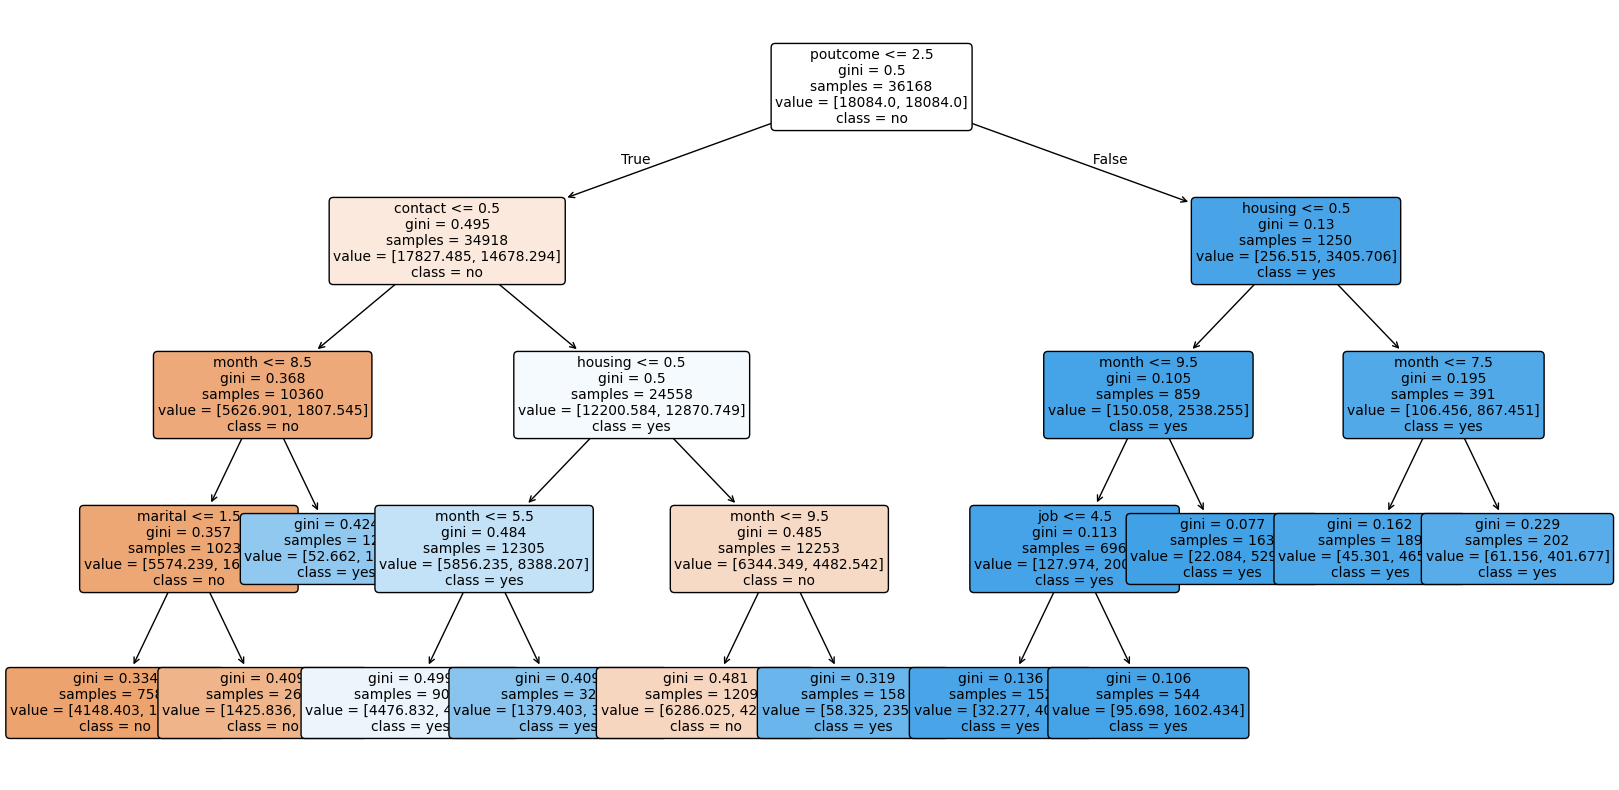

In [25]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
tree.plot_tree(
    model,
    feature_names=cat_cols,
    class_names=["no", "yes"],
    filled=True,
    rounded=True,
    max_depth=4,
    fontsize=10
)
plt.show()


In [19]:
train_data['DT_prob'] = y_prob

In [20]:
# encode categorical variables
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X = enc.fit_transform(test_data[cat_cols])
y = (test_data["y"] == "yes").astype(int).values

# evaluate
y_pred = model.predict(X)
y_prob = model.predict_proba(X)[:, 1]
print_metrics(y, y_pred, y_prob)

Confusion Matrix:
 [[5292 2694]
 [ 351  706]]

Classification Report:
               precision    recall  f1-score   support

           0      0.938     0.663     0.777      7986
           1      0.208     0.668     0.317      1057

    accuracy                          0.663      9043
   macro avg      0.573     0.665     0.547      9043
weighted avg      0.852     0.663     0.723      9043

ROC AUC: 0.7280


In [21]:
test_data['DT_prob'] = y_prob

# Saving Outputs

TODO: Uncomment them later

In [ ]:
# data = pd.read_excel('../../Data/train_data.xlsx')
# data = data.join(train_data.iloc[:, -4:])
# data = data.drop(columns = categorical_cols[1:-1])
# data.to_excel('../../Data/train_data_prob_added.xlsx', index = False)

In [ ]:
# data = pd.read_excel('../../Data/test_data.xlsx')
# data = data.join(test_data.iloc[:, -4:])
# data = data.drop(columns = categorical_cols[1:-1])
# data.to_excel('../../Data/test_data_prob_added.xlsx', index = False)

In [124]:
pd.read_excel('../../Data/test_data_prob_added.xlsx').iloc[:,-4:].corr()

,NB_prob,Logistic_prob,DT_prob,EBM_prob
NB_prob,1.000000,0.831144,0.734226,0.794400
Logistic_prob,0.831144,1.000000,0.768758,0.894297
DT_prob,0.734226,0.768758,1.000000,0.755623
EBM_prob,0.794400,0.894297,0.755623,1.000000
